# Sensor Based Irrigation with ESP32

Date 14/08/2021 

Adar Sulema, Gabriel Bar Sella

The Faculty of Agriculture, The Hebrew University of Jerusalem (ISRAEL)

***

## Introduction

In this project we used data collected by PM-WCS-3 Soil sensor and HX711 load cell using ESP32 in order to find change in soil moisture and weight to create a sensor based irrigation system.  

Automated Irrigation is very common in these days with everyone from hobby gardeners to commercial growers using some form of computer controlled irrigation. Most common systems are open loop systems where irrigation is applied at fixed time intervals. The next generation of automated irrigation are closed loop systems using data regarding parameters of soil, plant and environment to decide when to water and how much. In our project we made two closed loop systems of automatic irrigation based on two parameters - VWC and weight.


### VWC
**Volumetric Water Content** is defined by ratio between the volume of water to the volume of wet material and in our context is refered to as soil moisture.

Mathematically defined as:

$$ \theta = \frac{V_w}{V_{wet}} $$

$V_w$ is the volume of water

$V_{wet}$ is the total volume of wet matter represented as a sum of the volumes of solid, water and air. 
$$ V_{wet} = V_s + V_w + V_a $$

### Weight
The total weight of a potted plant is equivalent to the weight of the plant, soil, pot and water. Assuming that weight of soil and the pot do not change we can attribute all changes in weight to water irrigation and consumption and plant growth.

$$ m_{total} = m_{constant} + m_w + m_{plant} $$

In order to determine plant growth in mass we will use measured amounts of water. Whenever the maximum weight of the plant is greater than the last maximum weight the difference is attributed to gain in plant matter.

$$ Growth = m_{max2} - m_{max1} $$


#### Our goals:
* Soil moisture irrigation:
A system that starts watering when VWC goes under a certain threshold and stops when desired VWC is reached.
* Irrigation by weight:
A system that irrigates when the total weight goes under a certain threshold representing the loss of water. The system keeps record of the maximum weight everytime it is reached, updates plant growth in mass and threshold weight.

## Methods

#### Cloud Data Collection
In order to collect data we have used Thingspeak IoT platform, allowing a sample rate of 1 reading every 15 seconds. 


#### Interval Watering
For interval watering we decided to use the ESP32 ability to connect to the internet to use NTP protocol - allowing clock synchronization. This way the watering is always in the same time of the day and takes daylight saving in consideration. Clock synchronizaion also keeps the interval steady also if the systems fails or restarts. Besides from opening and closing times there was no additionaly gathered data for this system. To trigger watering User picks watering time and for how long watering will occur using a loop count (in 15 seconds increments)

In this test the plant was a sugar cane trigger time was 7:00AM and watering was set to 15 minutes which amounts to 1 liter.

For github folder with code and info [click here](https://github.com/adarsul/2021-AgroTech-Project/tree/main/Moisture%20Controlled)

#### Soil Moisture Sensor
A PM-WCS-3 soil sensor was used to track soil moisture. The instrument tracks EC, E25, Soil Temp and VWC. For our test we have collected data for soil temperature and VWC as a representation of soil moisture. User decides a minimum soil moisture value to trigger irrigation and a maximum value to halt irrigation. Samples are taken every second and trigger is checked every 15 seconds and sent to the cloud as well. Using a loop count we also incorporated a maximum length for watering to avoid flooding, therefore once watering is triggered it keeps going until the maximum moisture value is reached or the loop count reaches it's limit.

In this test the plant was a common reed, minimum moisture and maximum moisture were 60% and 90% respectively.

For github folder with code and info [click here](https://github.com/adarsul/2021-AgroTech-Project/tree/main/Moisture%20Controlled)


#### Scale 
For the weight controlled irrigation we used the HX711 20 kg loadcell. The intsrument converts force to electrical output values. In order to recieves weight values in grams calibration was needed. Using standard weights and a digital kitchen scale we took average readings for the weights on the kitchen scale and on the HX711 and created a linear regression to generate readings in grams. 

The user decides on minimum weight to trigger watering and maximum weight that refers to the weight of the pot after watering. Due to the tendency of values to flunctuate a sample is taken every second and a reading is generated every 15 seconds from an average of 15 samples. Watering duration is set by a loop counter in 15 seconds increments. When minimum weight is reached watering is activated for set amount of time. Assuming that all weight gain during watering is due to water, if current weight is greater than last maximum value then the difference is attributed to plant growth. The difference is added to the minimum weight and the maximum weight and to a growth tracker. Readings are sent to to cloud every 15 seconds.

In this test the plant was an eggplant, minimum weight and maximum weight were 3300 and 4100 grams respectively.

For github folder with seperate code and info [click here](https://github.com/adarsul/2021-AgroTech-Project/tree/main/Scale_Irrigation)



#### Unified System
In order to run 3 systems at once using the hardware we created a hybrid code that allowed all 3 systems to be connected to one ESP32 device. Codes for the 3 systems were modified and united in order to allow all triggers, watering and reading to happen simultaneously. For weight irrigation the sample rate was reduced resulting in lesser accuracy and for interval and moisture irrigation trigger checking was set to every 15 seconds. Data that was sent to the cloud by this system contained: weight for scale irrigation, VWC and soil temperature for moisture irrigation and on/off times for all 3.

For The code [click here](https://github.com/adarsul/2021-AgroTech-Project/tree/main/Scale_Irrigation)

For The wiring diagram [click here](https://github.com/adarsul/2021-AgroTech-Project/blob/main/Report/circuit%20schematic.jpg)  - credit to Shani and Nir.




## Results

#### General 

After downloading out data from thingspeak, we selected the relevant data for the expirement period.
We noticed that the "weightUpdate" function, responsible for updating the weight variables triggered only a few times and therefore we received very few observations for the 'Growth' parameter. We added in excel a coloumn of Max Weight and using it's values generated a Growth parameter that is derived from a calculation (sum of differences betweeb the weight and max weight) called "Growth Calculated". On the 4th and 6th of August the system has failed and has been restarted.


In [1]:
#Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from pylab import rcParams

file_path = 'https://github.com/adarsul/2021-AgroTech-Project/blob/main/Report/feeds%20-%20unified2.csv?raw=true' # enter your data file path here
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

C:\Users\adars\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname IDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,ID,Weight (g),VWC %,Soil Temp (Celsius),Interval Watering,Moisture Watering,Scale Watering,Growth (g),Calculated Growth (g),Max weight (g)
Date,,,,,,,,,,
2021-08-01 22:30:14,1,4115.58545,58.6,30.06,0,0,0,0.0,25.30713,4115.58545
2021-08-01 22:30:36,2,4125.30713,58.6,30.00,0,0,0,0.0,30.21680,4125.30713
2021-08-01 22:30:58,3,4130.21680,58.5,29.94,0,0,0,0.0,38.29199,4130.21680
2021-08-01 22:31:20,4,4138.29199,57.7,29.90,0,0,0,0.0,38.29199,4138.29199
2021-08-01 22:31:42,5,4135.84229,57.6,29.87,0,0,0,0.0,51.94336,4138.29199


The following plot shows the times that each system was triggered using "Interval Watering", "Moisture Watering" and "Scale Watering" parameters. A value of 1 means the watering was active and 0 is inactive. Interval watering was set every day to 7AM

Text(0, 0.5, 'On/Off')

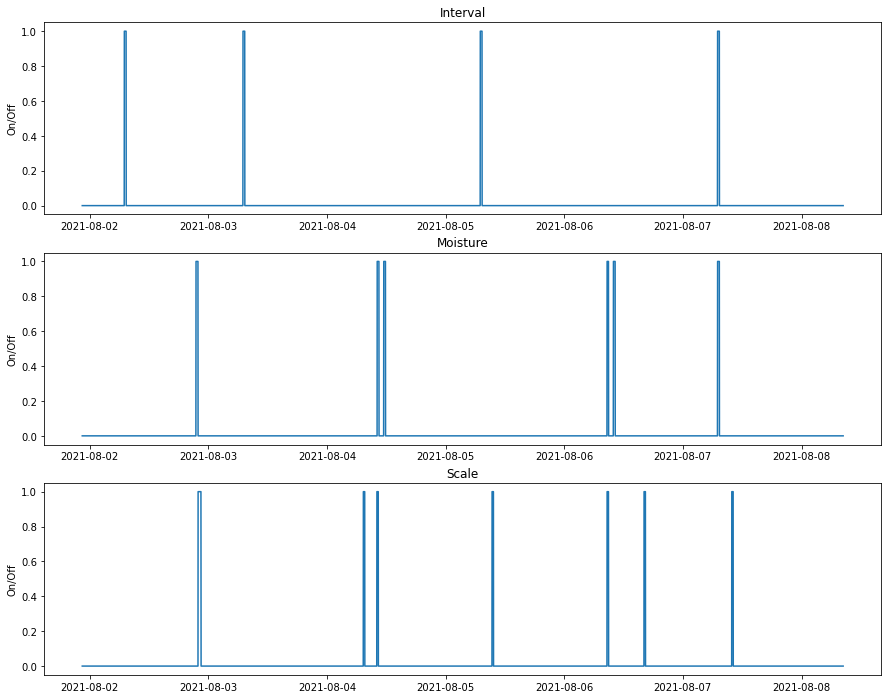

In [68]:
# First create a grid of plots
# ax will be an array of two Axes objects
fig, ax = plt.subplots(3, figsize = (15,12))

# Call plot() method on the appropriate object
ax[0].plot(df['Interval Watering'])
ax[0].set_title('Interval', fontsize=12)
ax[0].set_ylabel('On/Off')

ax[1].plot(df['Moisture Watering'])
ax[1].set_title('Moisture', fontsize=12)
ax[1].set_ylabel('On/Off')

ax[2].plot(df['Scale Watering'])
ax[2].set_title('Scale', fontsize=12)
ax[2].set_ylabel('On/Off')



In the first plot we see that the interval watering was not triggered on the 4th and 6th of August. By looking at the other plots, we can see that the system was restarted in ordert to intiate watering on the Moisture and Scale plots.

#### Moisture Sensor

Max VWC value was set to 60% and Min value was set to 40%

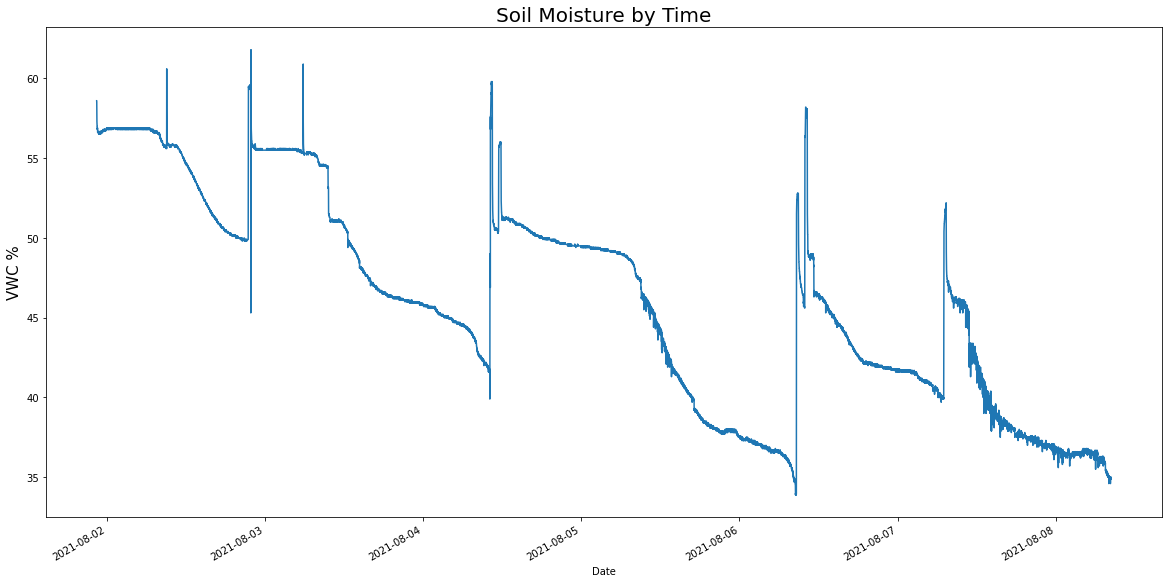

In [31]:
# visualisation of the data
df1 = df.loc[(df['VWC %'] >= 1)] #C
vwc = df1['VWC %'].plot(figsize=(20, 10))
vwc.set_title('Soil Moisture by Time', fontsize=20)
vwc.set_ylabel('VWC %', fontsize=15)
plt.show()

This graph describes the soil moisture recorded by the soil sensor along the experiment without readings under 0. According to this graph the moisture controlled watering has triggered when the VWC was at 50%, 40%, 35% and again at 40%.

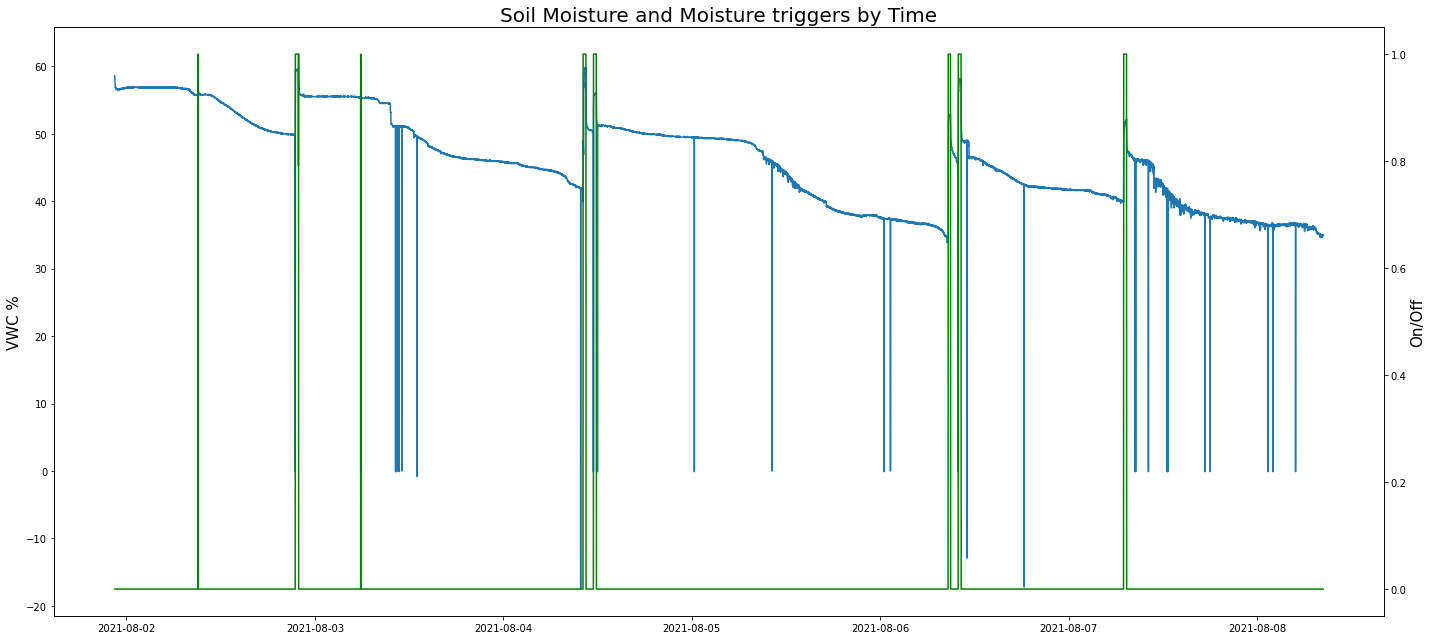

In [34]:
fig, ax1 = plt.subplots(figsize = (20,9))
ax1.plot(df['VWC %'])
ax1.set_ylabel('VWC %', fontsize=15)
ax2 = ax1.twinx()
ax2.plot(df['Moisture Watering'], color='green')
ax2.set_ylabel('On/Off', fontsize=15)
ax1.set_title('Soil Moisture and Moisture triggers by Time', fontsize=20)
fig.tight_layout()
plt.show()

This graph shows the unfiltered data of VWC and Moisture watering activation. In this plot we can see that there were quite a few sensor errors sending low values triggering the system at unwanted times. On the other hand, on multiple occasions the low values also did not trigger the watering.

#### Scale

Eggplant on day 1:
<div>
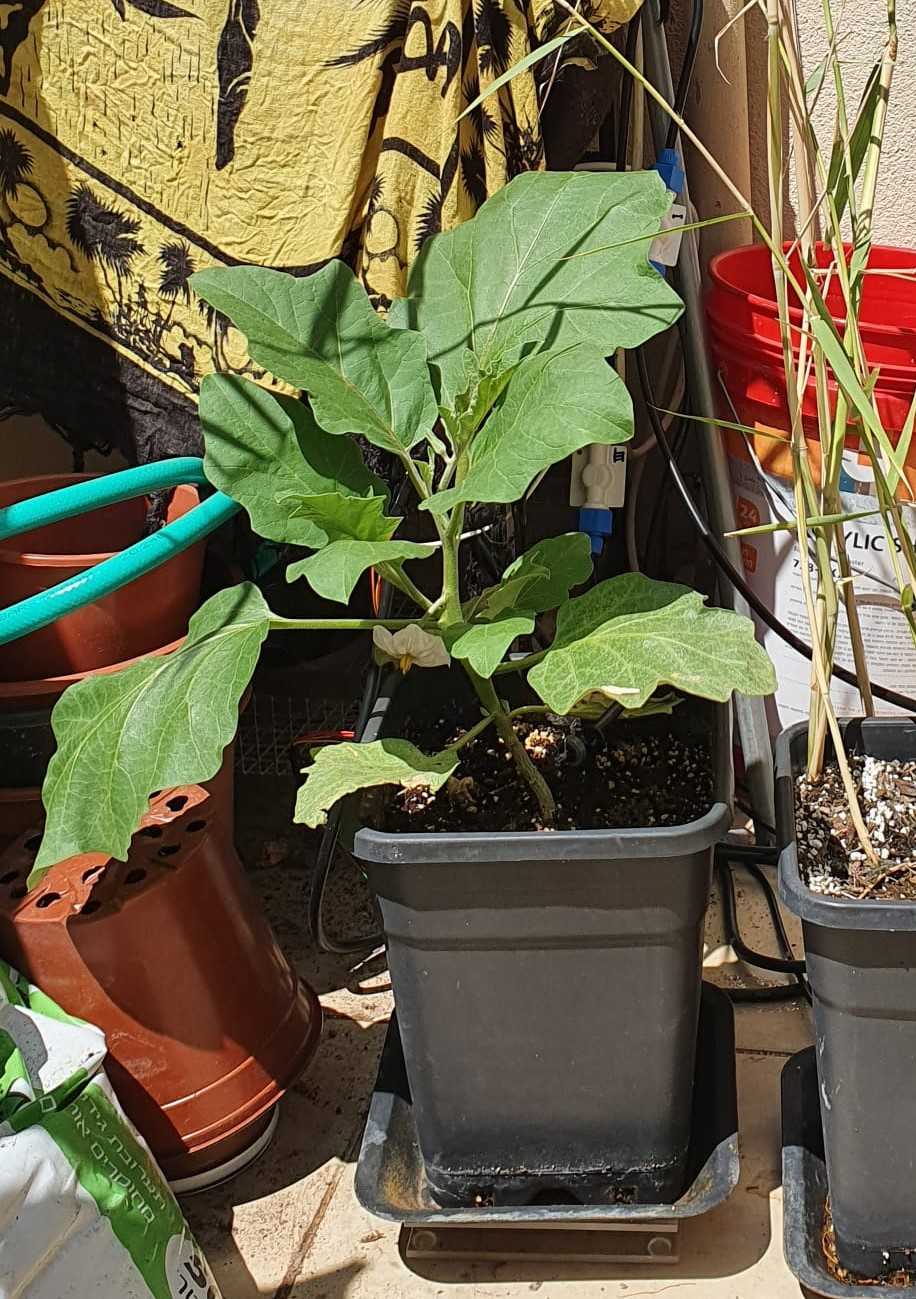
</div>



Eggplant on day 7:
<div>
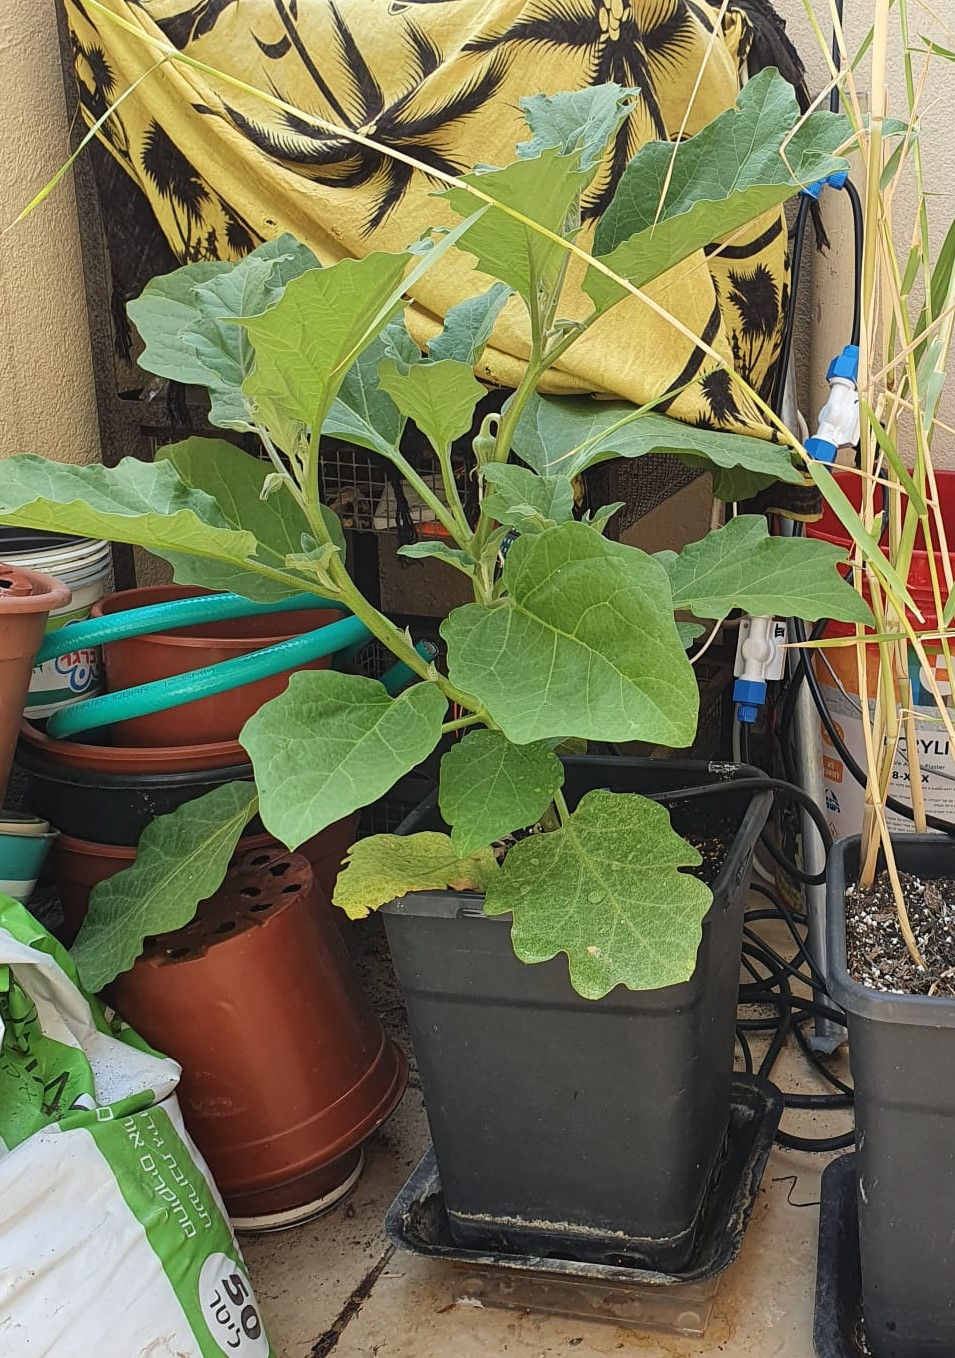
</div>


Max weight for the scale sensor was set to 4100 and Min weight was set to 3300. 

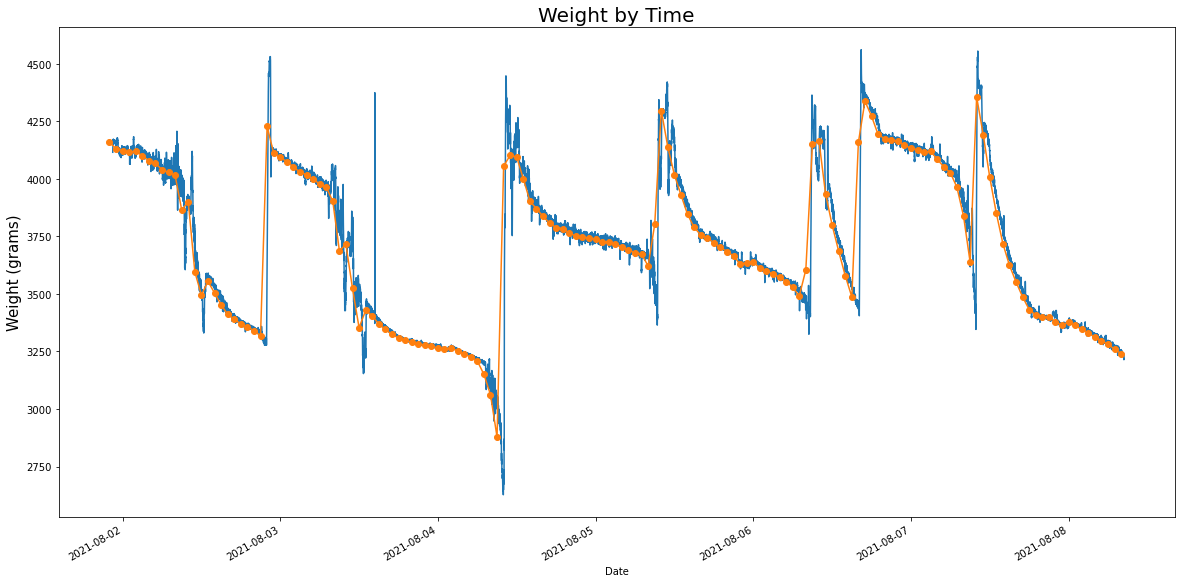

In [35]:
# visualisation of the data
df2 = df.loc[(df['Weight (g)'] > 0)] #C
weight = df2['Weight (g)'].plot(figsize=(20, 10))
weight.set_title('Weight by Time', fontsize=20)
weight.set_ylabel('Weight (grams)', fontsize=15)
df2['Weight (g)'].resample("H").mean().plot(style="-o",);
plt.show()

In this plot the blue line is all of the weight observations and the orange dots represent an hourly timescale. The scale weight sensor is known to give out flunctuating values therefore the hour time sale gives an indication of the distortion. 

By this graph it seems that watering has triggered at 3250, 2600, 3300 and 3400 grams. There's also a very high oultier on the 3rd of August.


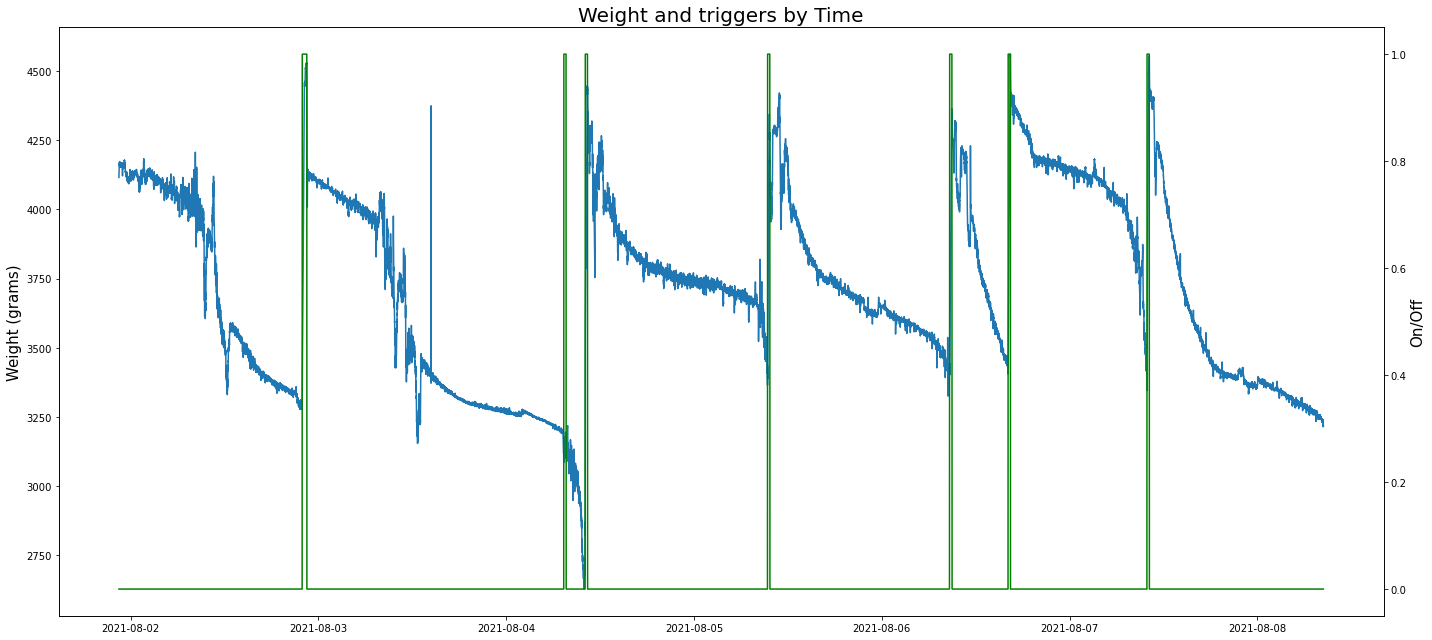

In [38]:
fig, ax1 = plt.subplots(figsize = (20,9))
ax1.plot(df['Weight (g)'])
ax1.set_title('Weight and triggers by Time', fontsize=20)
ax1.set_ylabel('Weight (grams)', fontsize=15)
ax2 = ax1.twinx()
ax2.plot(df['Scale Watering'], color='green')
ax2.set_ylabel('On/Off', fontsize=15)
fig.tight_layout()
plt.show()

In this graph we see the actual triggers along the weight. On the 4th the system was restarted because the water was closed, The scale watering triggered but no water came out.


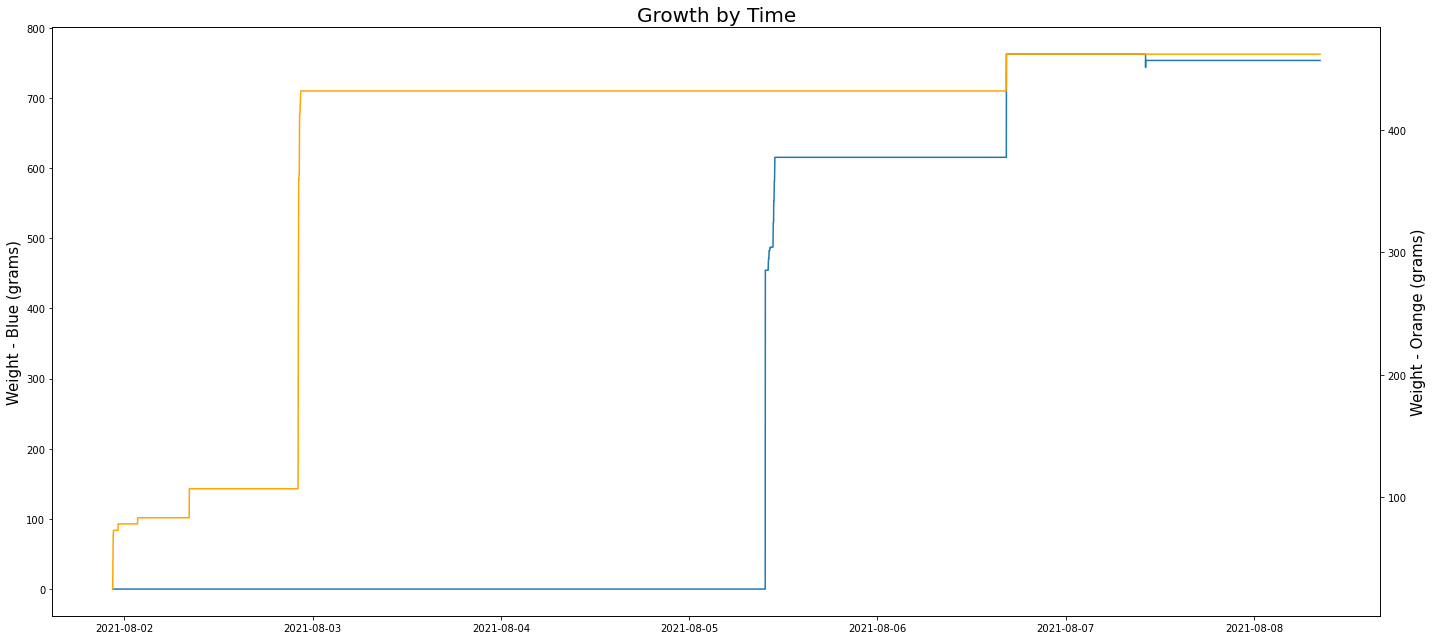

In [49]:
fig, ax1 = plt.subplots(figsize = (20,9))
ax1.plot(df['Growth (g)'])
ax1.set_title('Growth by Time', fontsize=20)
ax1.set_ylabel('Weight - Blue (grams)', fontsize=15)
ax2 = ax1.twinx()
ax2.plot(df['Calculated Growth (g)'], color = 'orange')
ax2.set_ylabel('Weight - Orange (grams)', fontsize=15)
fig.tight_layout()
plt.show()

Yellow line - Calculated Growth

Blue line - Recorded Growth Variable

Green line - Weight Triggered Watering

In this plot we see that the growth did not record well. The function that updates the growth parameter was under a condition where it was activated only during waterings and if the weight after a watering was greater than the set Max Weight. The calculated growth data was made using the difference between the current weight to the max weight difference.

The recorded growth gave much higher readings by up to 400 grams. It is likely that the calculated growth is more accurate as it is not affected by a system restart.

## Discussion

Although far from perfect, the system we made has successfuly watered plants using sensor readings and sent data for analysis. All plants have show visible growth and good health during the expirement. By the data collected in the experiment we estimate that the eggplant plant gained roughly between 400 - 700 grams of biomass.

The main flaws of the system were:

#### - Inconsistent Trigerring

Required us to restart the system twice within the experiment. We believe that the main reasons behind this could be code flaws or due to hardware overheating. The system was placed on a porch in Tel Aviv at august under extremely hot weather conditions that might have caused hardware failure.

##### possible solutions: 
- We changed the trigger condition from the counter variables to the boolean values.
- On future projects try to create better casing for hardware or have the sensitive components indoors with long wires to the measuring instruments.
- Watering algorithm for both scale and moisture sensor could be rewrtiten and improved. 


#### - Soil Moisture Sensor Error Values

The soil moisture sensor occasionally had reading errors where it sent values of 0 or under 0 which at some occasion triggered watering and quite probably disrupted the watering function. This could have affected the systems triggering as well on the whole system.

##### possible solutions: 
- The condition for watering could be changed to water only if the soil moisture value has been under the threshold for a certain amount of time. This way an occassional misread will not trigger watering.
- Better quality sensor.

#### - Growth Variable Not Recording

The weight triggered watering was supposed to track and store the difference between maximum weight values in order to calculate the growth in biomass. We have programed the weightUpdate function to be called only after watering in order to eliminate the possibilty that accidently applied pressure will change the weight values. In practice, on the first part of the experiment (until the restart on the 4th) the function was not called even though the readings showed that the conditions was met. 
##### possible solutions: 
- Change the code so that the weightUpdate function is called every loop instead of only after a watering. 
- Change the code so that GROWTH variable value is sent to Thingspeak on every loop instead of only when the function is called.


#### - Irregular Watering Times

Only the interval watering watered at consistent times and in the morning. The soil moisture and weight triggered the watering mostly at the afternoon and early evening causing the system to water at irregular times. The main problem with this is that the water in the hoses in the afternoon is very hot and could harm roots. When watered at night, the lower water consumption by the plant would leave the soil wet overnight which increases the risk of soil pathogen development. 

##### possible solutions: 
- Change the program so that thresholds for watering are checked every morning at a set hour. For example: if the weight at 7 is under 3kg give 1 liter of water, during the day trigger the watering to maintain weight over 3.2 kilos.
- Alternitavely the triggering could be conditioned to a time period. For example: if VWC is under 60% between 7 AM and 9 AM give water until VWC 60% is restored. 


#### - Scale precision
The scale constantly gave flunctuating readings, sometimes with a range of over 200 grams. To overcome this we have used heavier subjects to minimize the error percentage.

##### possible solutions: 
- Possibly a scale designed for a lower weight load could give more accurate readings.
- Use heavier pots and plants.


### Conclusions and Further Improvements

We are satisfied with the outcomes of our project as we believe we have gained important experience and insights regarding the creation of a smart precision watering system. We believe that out of the 3 methods in the current form the most consistent would be the Interval method and that most exact would be the Scale method. The moisture method worked better than the scale watering but the readings are less indicative as they only sense the upper layer of soil. Ideally we believe that the best system should be using a combination of the 3 methods: Monitoring weight and VWC and using the values to trigger watering while using the Time from the interval method to decide whether or not to water. 

#### More possible features:
- Updating thresholds and weight values without disconnecting the system online. This could be done using HTML as seen in this [tutorial](https://randomnerdtutorials.com/esp32-esp8266-input-data-html-form/)
- Storing Weight and growth values on memory or enabling the system to download past values. This would enable the system to continue from the same point and not return to the initial values if restarted.
- Longer period analysis of the relations between weight, soil VWC and VPD (collected by climate sensor) to find better ways to trigger the watering in ideal timing.
- Develop a watering algorithm for the weight sensor that is based on the slope (rate of weight increase/decrease) to to trigger watering on or off.
- Use other sensors to try and find correlations to VWC and water content by weight.